## Goals
#### Q2: Does the current formulation of Consensus Pledge, when modified to remove the baseline in the denominator, stabilise at 30% of circulating supply locked in the long-time limit?

1. Scenarios
    a. Code change:
        i. Remove baseline denominator in Consensus Pledge
    b. Power Scenario:
        i. Typical QAP trajectory - baseline crossing this year
2. Metrics
    a. L/CS
    b. L/AS

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import numpy as np
import pandas as pd

import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.dates as mdates
import matplotlib.cm as cm

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import requests
import datetime
import copy
import math
import pickle

from tqdm.auto import tqdm
from datetime import timedelta, date
import time
import os
import numbers

import warnings
warnings.filterwarnings('ignore')

from jax import random
import numpyro
import numpyro.distributions as dist

from numpyro.infer import MCMC, NUTS, Predictive
import jax.random as random
import jax.numpy as jnp

import scenario_generator.curated as curated
import scenario_generator.mcmc_forecast as mcmc
import scenario_generator.utils as u

import mechafil.data as mechafil_data
from mechafil.sim import run_simple_sim
from mechafil.data import get_historical_network_stats, get_sector_expiration_stats, \
    query_sector_expirations, get_cum_capped_qa_power
from mechafil.power import forecast_power_stats, build_full_power_stats_df
from mechafil.vesting import compute_vesting_trajectory_df
from mechafil.minting import compute_minting_trajectory_df, \
    network_time, cum_baseline_reward, compute_baseline_power_array
from mechafil.supply import forecast_circulating_supply_df
import mechafil.locking as locking

from joblib import Parallel, delayed
import dill as pickle
from joblib import parallel_backend
from joblib import wrap_non_picklable_objects

In [3]:
offline_folder = 'offline_info'
results_folder = 'results'
os.makedirs(offline_folder, exist_ok=True)
os.makedirs(results_folder, exist_ok=True)

In [4]:
NDEVICES = 2 
numpyro.set_host_device_count(NDEVICES)

# Data starts in filecoin_daily_stats 2021-03-15
# genesis block was in 2020-08-24
# Main net launch was in 2020-10-15

# set the simulation start date
today = datetime.date(2023, 5, 1)
DATA_LAG_DAYS = 0
current_date = today - timedelta(days=(DATA_LAG_DAYS))
current_day = (current_date - date(2020, 10, 15)).days

start_date = datetime.date(2022, 6, 1)
start_day = (start_date - datetime.date(2020, 10, 15)).days

# Forecast timeframe
forecast_lenght = int(365*10)
end_day = current_day + forecast_lenght
end_date = current_date + datetime.timedelta(days=forecast_lenght)

print(start_date)
print(current_date)
print(end_date)

2022-06-01
2023-05-01
2033-04-28


In [5]:
mechafil_data.setup_spacescope('/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json')

In [6]:
fpp = os.path.join(offline_folder, 'historical_inputs.pkl')
if os.path.exists(fpp):
    with open(fpp, 'rb') as f:
        z = pickle.load(f)
    t_rr = z['t_rr']
    historical_rr = z['rr']
    t_fpr = z['t_fpr']
    historical_fpr = z['fpr']
    t_rbp = z['t_rbp']
    historical_rbp = z['rbp']
else:
    t_rr, historical_rr = u.get_historical_renewal_rate(start_date, current_date)
    t_fpr, historical_fpr = u.get_historical_filplus_rate(start_date, current_date)
    t_rbp, historical_rbp = u.get_historical_daily_onboarded_power(start_date, current_date)

    save_dict = {
        't_rr': t_rr,
        'rr': historical_rr,
        't_fpr': t_fpr,
        'fpr': historical_fpr,
        't_rbp': t_rbp,
        'rbp': historical_rbp
    }
    with open(fpp, 'wb') as f:
        pickle.dump(save_dict, f)

In [7]:
fp = os.path.join(offline_folder, 'historical_network_stats.pkl')
if os.path.exists(fp):
    with open(fp, 'rb') as f:
        z = pickle.load(f)
    fil_stats_df = z['fil_stats_df']
    sector_expiration_stats_offline = z['sector_expiration_stats']
else:
    fil_stats_df = get_historical_network_stats(start_date,current_date,end_date)
    sector_expiration_stats_offline = get_sector_expiration_stats(start_date, current_date,end_date)
    
    dict_out = {
        'fil_stats_df': fil_stats_df,
        'sector_expiration_stats': sector_expiration_stats_offline
    }
    with open(fp, 'wb') as f:
        pickle.dump(dict_out, f)
        
# handy constants
EIB = 2 ** 60
PIB = 2 ** 50
TIB = 2 ** 40
GIB = 2 ** 30
SECTOR_SIZE = 32 * GIB
EPOCH_PER_DAY = 2880

MEGA = 1_000_000

In [8]:
def filter_df_date(df_in, min_date, max_date):
    df_out = df_in[(df_in['date']>= pd.to_datetime(min_date)) & (df_in['date']<=pd.to_datetime(max_date))]
    return df_out

def clip_all_powers(df_in, v=1e-6):
    """
    'onboarded_power', 'cum_onboarded_power',
    'expire_scheduled_power', 'cum_expire_scheduled_power', 'renewed_power',
    'cum_renewed_power', 'total_power', 'power_type', 'total_qa_power_eib'
    """
    df_out = df_in.copy()
    for c in df_out.columns:
        if 'power' in c and c != 'power_type':
            df_out[c] = df_out[c].clip(lower=v)
    return df_out

def add_generated_quantities(cil_rbp, duration=365)->pd.DataFrame:
    # add ROI to trajectory df
#     df['day_pledge_per_QAP'] = SECTOR_SIZE * df['day_locked_pledge'] / (df['day_onboarded_power_QAP'] + df['day_renewed_power_QAP'])
    cil_rbp['day_pledge_per_QAP'] = SECTOR_SIZE * (cil_rbp['day_locked_pledge']-cil_rbp['day_renewed_pledge'])/(cil_rbp['day_onboarded_power_QAP'])
    cil_rbp['day_rewards_per_sector'] = SECTOR_SIZE * cil_rbp.day_network_reward / cil_rbp.network_QAP
    
    cil_rbp['1y_return_per_sector'] = cil_rbp['day_rewards_per_sector'].rolling(365).sum().shift(-365+1).values.flatten()
    cil_rbp['1y_sector_roi'] = cil_rbp['1y_return_per_sector'] / cil_rbp['day_pledge_per_QAP']

    cil_rbp['3y_return_per_sector'] = cil_rbp['day_rewards_per_sector'].rolling(365*3).sum().shift(-365*3+1).values.flatten()
    cil_rbp['3y_sector_roi'] = cil_rbp['3y_return_per_sector'] / cil_rbp['day_pledge_per_QAP']
    cil_rbp['3y_roi_annualized'] = np.power(cil_rbp['3y_sector_roi'] + 1, 1./3) - 1
    return cil_rbp

def run_sim(rb_onboard_power_pred_IN, renewal_rate_vec_pred_IN, fil_plus_rate_pred_IN,
            simulation_name='abc',
            duration=365, duration_m=None, qap_mode='basic', intervention_config={},
            sector_expiration_stats_IN=sector_expiration_stats_offline):
    
    mechafil_data.setup_spacescope('/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json')
    
    # api for power-forecasting and circ-supply are slightly different
    print(len(historical_rr), len(renewal_rate_vec_pred_IN))
    renewal_rate_vec_IN = np.concatenate([historical_rr, renewal_rate_vec_pred_IN])    

    if sector_expiration_stats_IN is None:
        res = get_sector_expiration_stats(start_date, current_date,end_date)
    else:
        res = sector_expiration_stats_IN
    rb_known_scheduled_expire_vec = res[0]
    qa_known_scheduled_expire_vec = res[1]
    known_scheduled_pledge_release_full_vec = res[2]
    
    current_day_stats = fil_stats_df.iloc[-1]
    
    rb_power_zero = current_day_stats["total_raw_power_eib"] * 1024.0
    qa_power_zero = current_day_stats["total_qa_power_eib"] * 1024.0

    rb_power_df, qa_power_df = forecast_power_stats(
        rb_power_zero,
        qa_power_zero,
        rb_onboard_power_pred_IN,
        rb_known_scheduled_expire_vec,
        qa_known_scheduled_expire_vec,
        renewal_rate_vec_IN[-int(forecast_lenght):],
        fil_plus_rate_pred_IN,
        duration,
        forecast_lenght,
        duration_m=duration_m,
        qap_method=qap_mode,
        intervention_config=intervention_config,
        fpr_hist_info=(t_fpr, historical_fpr)
    )

    ########## BUG FIX
    rb_power_df = clip_all_powers(rb_power_df)
    qa_power_df = clip_all_powers(qa_power_df)
    ##########
    rb_power_df["total_raw_power_eib"] = rb_power_df["total_power"]/1024.0
    qa_power_df["total_qa_power_eib"] = qa_power_df["total_power"]/1024.0
        
    power_df = build_full_power_stats_df(
        fil_stats_df,
        rb_power_df,
        qa_power_df,
        start_date,
        current_date,
        end_date,
    )
    
    rb_total_power_eib = power_df["total_raw_power_eib"].values
    qa_total_power_eib = power_df["total_qa_power_eib"].values
    qa_day_onboarded_power_pib = power_df["day_onboarded_qa_power_pib"].values
    qa_day_renewed_power_pib = power_df["day_renewed_qa_power_pib"].values

    vest_df = compute_vesting_trajectory_df(start_date, end_date)
    
    mint_df_rbpbase = compute_minting_trajectory_df(
        start_date,
        end_date,
        rb_total_power_eib,
        qa_total_power_eib,
        qa_day_onboarded_power_pib,
        qa_day_renewed_power_pib,
        minting_base = 'rbp'
    )
    
    start_day_stats = fil_stats_df.iloc[0]
    circ_supply_zero = start_day_stats["circulating_fil"]
    locked_fil_zero = start_day_stats["locked_fil"]
    burnt_fil_zero = start_day_stats["burnt_fil"]
    daily_burnt_fil = intervention_config['burn_boost_value'] * fil_stats_df["burnt_fil"].diff().mean()
    burnt_fil_vec = fil_stats_df["burnt_fil"].values

    cil_df_rbp = forecast_circulating_supply_df(
        start_date,
        current_date,
        end_date,
        circ_supply_zero,
        locked_fil_zero,
        daily_burnt_fil,
        duration,
        renewal_rate_vec_IN,
        burnt_fil_vec,
        vest_df,
        mint_df_rbpbase,
        known_scheduled_pledge_release_full_vec,
        lock_target=0.3,  # the historical baseline lock target
        fil_plus_rate=fil_plus_rate_pred_IN,
        intervention_config=intervention_config,
        fpr_hist_info=(t_fpr, historical_fpr)
    )
    
    rbp_roi = add_generated_quantities(cil_df_rbp, duration=duration)
    
    return_dict = {
        'power_df': power_df,
        'rb_power_df': rb_power_df,
        'qa_power_df': qa_power_df,
        'mint_df': mint_df_rbpbase,
        'rbp_roi': rbp_roi,
        'renewal_rate_vec': renewal_rate_vec_IN,
        'rb_onboard_power_pred': rb_onboard_power_pred_IN,
        'fil_plus_rate_pred': fil_plus_rate_pred_IN,
        'sim_name': simulation_name
    }
    
    return return_dict

In [9]:
baseline_forecast = compute_baseline_power_array(current_date, end_date) / EIB

In [10]:
intervention_date=datetime.date(2023,5,15)
duration_m = lambda d: (1 if d <= round(365*1.5) else (d-183)/365)
duration_m_none = lambda d: 1
num_days_shock_behavior = 360
days_to_target=1

qap_mode = 'basic-sdm'

# mcmc_scenario = {
#     'rb_onboard_power': np.median(np.asarray(rb_onboard_power_pred), axis=0), 
#     'renewal_rate': np.median(np.asarray(renewal_rate_pred), axis=0), 
#     'filplus_rate': np.median(np.asarray(filplus_rate_pred), axis=0)
# }

current_rbp = np.mean(historical_rbp[-90:])
current_rr = np.mean(historical_rr[-90:])
current_fpr = np.mean(historical_fpr[-90:])
lock_target = 0.3  # this is needed for config, but is the status quo

sim_vec=[]
durations_vec_yrs=[1,3,5]
for duration_yr in durations_vec_yrs:
    duration_days = duration_yr * 365
    
    # Standard QAP trajectory
    #  NOTE: can change to MCMC
    rbp_forecast = np.ones(forecast_lenght)*current_rbp
    rr_forecast = np.ones(forecast_lenght)*current_rr
    fpr_forecast = np.ones(forecast_lenght)*current_fpr
    
    standard_qap_trajectory_cfg = {
        'name': 'StandardQAPTrajectory_SectorDuration=%d' % (duration_yr,), 
        'rbp': copy.deepcopy(rbp_forecast),
        'rr': copy.deepcopy(rr_forecast),
        'fpr': copy.deepcopy(fpr_forecast),
        'kwargs':{
            'duration': duration_days, 
            'duration_m': duration_m_none,
            'qap_mode': qap_mode,      
            # NOTE: all the cfg below is standard, but we are using this branch to be 
            # consistent across simulations
            'intervention_config': {
                'type': 'noop',
                'num_days_shock_behavior': num_days_shock_behavior,
                'intervention_date': intervention_date,
                'simulation_start_date': current_date + datetime.timedelta(days=1),
                'sdm_onboard_before_intervention': False,
                'sdm_onboard_after_intervention': False,
                'sdm_renew_before_intervention': False,
                'sdm_renew_after_intervention': False,
                'lock_target_update_date': intervention_date,
                'lock_target_update_value': lock_target,
                'burn_boost_value': 1,
                'consensus_pledge_method_before_intervention': 'circulating_supply',
                'consensus_pledge_method_after_intervention': 'circulating_supply',
                'onboard_ratio_callable': locking.no_baseline_onboard_ratio
            }
        }
    }
    sim_vec.append(copy.deepcopy(standard_qap_trajectory_cfg))
    
#     # QAP = baseline trajectory
#     rbp_forecast = np.diff(baseline_forecast, prepend=baseline_forecast[0])* ((EIB / PIB) / 10) # scale by 10 for QA
#     rr_forecast = np.ones(forecast_lenght)*current_rr
#     fpr_forecast = np.ones(forecast_lenght)*1.00
    
#     control_cfg1 = {
#         'name': 'QAPEqBaseline_SectorDuration=%d' % (duration_yr,),  
#         'rbp': copy.deepcopy(rbp_forecast),
#         'rr': copy.deepcopy(rr_forecast),
#         'fpr': copy.deepcopy(fpr_forecast),
#         'kwargs':{
#             'duration': duration_days, 
#             'duration_m': duration_m_none,
#             'qap_mode': qap_mode,      
#             # NOTE: all the cfg below is standard, but we are using this branch to be 
#             # consistent across simulations
#             'intervention_config': {
#                 'type': 'noop',
#                 'num_days_shock_behavior': num_days_shock_behavior,
#                 'intervention_date': intervention_date,
#                 'simulation_start_date': current_date + datetime.timedelta(days=1),
#                 'sdm_onboard_before_intervention': False,
#                 'sdm_onboard_after_intervention': False,
#                 'sdm_renew_before_intervention': False,
#                 'sdm_renew_after_intervention': False,
#                 'lock_target_update_date': intervention_date,
#                 'lock_target_update_value': lock_target,
#                 'burn_boost_value': 1,
#                 'consensus_pledge_method_before_intervention': 'circulating_supply',
#                 'consensus_pledge_method_after_intervention': 'circulating_supply',
#                 'onboard_ratio_callable': locking.no_baseline_onboard_ratio
#             }
#         }
#     }
#     sim_vec.append(copy.deepcopy(control_cfg1))
    
    # QAP > baseline trajectory
    rbp_forecast = 2.5 * np.diff(baseline_forecast, prepend=baseline_forecast[0])* ((EIB / PIB) / 10) # scale by 10 for QA
    rr_forecast = np.ones(forecast_lenght)*current_rr
    fpr_forecast = np.ones(forecast_lenght)*1.00
    
    control_cfg2 = {
        'name': 'QAP-GT-Baseline_SectorDuration=%d' % (duration_yr,),  
        'rbp': copy.deepcopy(rbp_forecast),
        'rr': copy.deepcopy(rr_forecast),
        'fpr': copy.deepcopy(fpr_forecast),
        'kwargs':{
            'duration': duration_days, 
            'duration_m': duration_m_none,
            'qap_mode': qap_mode,      
            # NOTE: all the cfg below is standard, but we are using this branch to be 
            # consistent across simulations
            'intervention_config': {
                'type': 'noop',
                'num_days_shock_behavior': num_days_shock_behavior,
                'intervention_date': intervention_date,
                'simulation_start_date': current_date + datetime.timedelta(days=1),
                'sdm_onboard_before_intervention': False,
                'sdm_onboard_after_intervention': False,
                'sdm_renew_before_intervention': False,
                'sdm_renew_after_intervention': False,
                'lock_target_update_date': intervention_date,
                'lock_target_update_value': lock_target,
                'burn_boost_value': 1,
                'consensus_pledge_method_before_intervention': 'circulating_supply',
                'consensus_pledge_method_after_intervention': 'circulating_supply',
                'onboard_ratio_callable': locking.no_baseline_onboard_ratio
            }
        }
    }
    sim_vec.append(copy.deepcopy(control_cfg2))

In [11]:
idxs = range(len(sim_vec))
duration_loop_results = {}

n_jobs = 6
results = Parallel(n_jobs=n_jobs)(delayed(run_sim)(
    sim_vec[i]['rbp'], sim_vec[i]['rr'], sim_vec[i]['fpr'], simulation_name=sim_vec[i]['name'], **sim_vec[i]['kwargs']
) for i in tqdm(idxs))

# convert the list into a dictionary to keep API
for res in results:
    duration_loop_results[res['sim_name']] = res

  0%|          | 0/6 [00:00<?, ?it/s]

/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these wil

In [12]:
plt_max = date(2033, 1, 1)

def plt_network_metrics(df_summaries, exp_configs_to_plot, plot_kwargs_list,
                        scale_by=EIB, 
                        sup_title_str='',
                        smooth_by=1,
                        save_fp=None):
#     # define plot settings and palette
#     plt.rcParams.update({'font.size': 18})
#     plt.rcParams["figure.figsize"] = (18,18)
    
    fig, axs = plt.subplots(2,2, constrained_layout=True, figsize=(8,6))
    rolling_fn = lambda x: np.nanmedian(x)
    
    for ii, exp_config in enumerate(exp_configs_to_plot):
        plt_kwargs = plot_kwargs_list[ii]
        
        cil_df_summary = df_summaries[exp_config]['rbp_roi']
        cil_df_summary = cil_df_summary[cil_df_summary['date'] <= pd.to_datetime(plt_max)]
        dates_ = cil_df_summary['date']
        bl = cil_df_summary['network_baseline'] / scale_by

        q50_t = cil_df_summary['network_QAP'] / scale_by
        # plot QAP predictions
        axs[0,0].plot(dates_, q50_t, **plt_kwargs)
        axs[0,0].tick_params(axis='x', labelrotation = 30)
        axs[0,0].set_title('Network QAP')
        axs[0,0].set_ylabel('EiB')
        axs[0,0].set_yscale('log')
        if ii == 0:
            axs[0,0].plot(dates_, bl, color='k', linestyle=':')
        axs[0,0].legend(fontsize=6)
       
        # plot daily locked pledge
        kk = 'day_locked_pledge'; ktitle = 'Daily Locked Pledge'
        q50_t = cil_df_summary[kk] 
        axs[0,1].plot(dates_, q50_t.rolling(7).apply(rolling_fn), **plt_kwargs)
        axs[0,1].tick_params(axis='x', labelrotation = 30)
        axs[0,1].set_title(ktitle)
        axs[0,1].set_ylabel('FIL/day')
        axs[0,1].set_yscale('log')
        
        # plot L/CS
        q50_t = cil_df_summary['network_locked'] / cil_df_summary['circ_supply'] * 100
        axs[1,0].plot(dates_, q50_t.rolling(7).apply(rolling_fn), **plt_kwargs)
        axs[1,0].tick_params(axis='x', labelrotation = 30)
        axs[1,0].set_title('L/CS')
        axs[1,0].set_ylabel('%')
        if ii == 0:
            axs[1,0].plot(dates_, np.ones(len(dates_))*lock_target*100, color='k', linestyle=':')
        
        # plot L/AS
        q50_t = cil_df_summary['network_locked'] / (cil_df_summary['circ_supply'] + cil_df_summary['network_locked']) * 100
        axs[1,1].plot(dates_, q50_t.rolling(7).apply(rolling_fn), **plt_kwargs)
        axs[1,1].tick_params(axis='x', labelrotation = 30)
        axs[1,1].set_title('L/AS')
        axs[1,1].set_ylabel('%')
        if ii == 0:
            axs[1,1].plot(dates_, np.ones(len(dates_))*lock_target*100, color='k', linestyle=':')


    plt.suptitle(sup_title_str)
    plt.tight_layout()
    
    if save_fp is not None:
        plt.savefig(save_fp)

In [13]:
exps_to_plot = []
plt_kwargs_list = []
colors_ = [
    mpl.colormaps['Blues'],
    mpl.colormaps['Oranges'],
    mpl.colormaps['Purples'],
    mpl.colormaps['Greens'],
    mpl.colormaps['Reds']
]
cmap_access_vec = np.linspace(0.2,0.8, len(durations_vec_yrs))

for ii, duration_yr in enumerate(durations_vec_yrs):
    exps_to_plot.append('StandardQAPTrajectory_SectorDuration=%d' % (duration_yr,))
    plt_kwargs_list.append({'color': colors_[0](cmap_access_vec[ii]), 'label':'Standard-Dur=%d' % (duration_yr,)})
# for ii, duration_yr in enumerate(durations_vec_yrs):
#     exps_to_plot.append('QAPEqBaseline_SectorDuration=%d' % (duration_yr,))
#     plt_kwargs_list.append({'color': colors_[1](cmap_access_vec[ii]), 'label':'QAP=Baseline-Dur=%d' % (duration_yr,)})
for ii, duration_yr in enumerate(durations_vec_yrs):
    exps_to_plot.append('QAP-GT-Baseline_SectorDuration=%d' % (duration_yr,))
    plt_kwargs_list.append({'color': colors_[2](cmap_access_vec[ii]), 'label':'QAP>Baseline-Dur=%d' % (duration_yr,)})

<IPython.core.display.Javascript object>


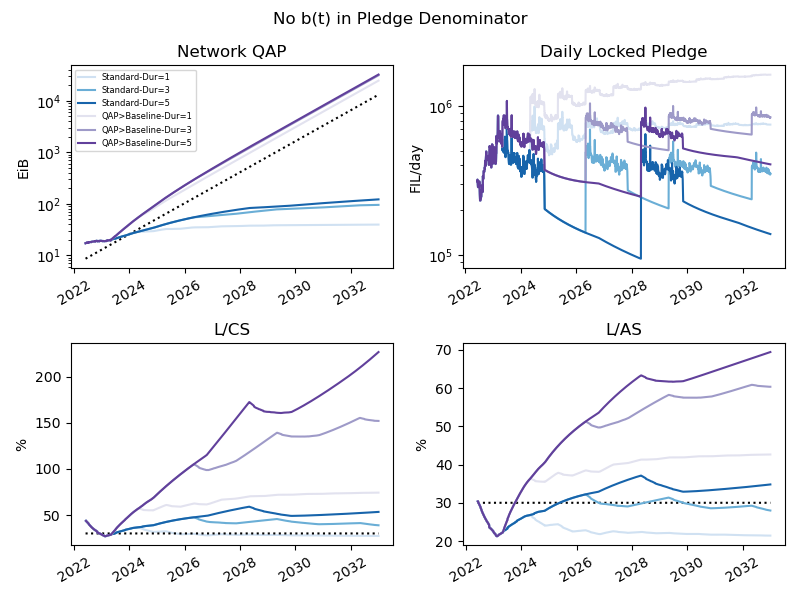

In [14]:
plt_network_metrics(duration_loop_results,exps_to_plot,plt_kwargs_list,
                    scale_by=EIB, 
                    sup_title_str='No b(t) in Pledge Denominator',
                    smooth_by=1,
                   save_fp=os.path.join(results_folder, 'baseline_q1_nobaselinedenom.png'))